In [22]:
import numpy as np  
import matplotlib.pyplot as plt
import pandas as pd
import cv2
from typing import Tuple

In [23]:
# Load images
img_sample_mosaic_01 = plt.imread('mosaic_art/sample_1.jpeg')

In [24]:
def angle_between_lines(line1: Tuple, line2: Tuple) -> float:
    """Calculate the angle between two lines in degrees.
    Args:
        line1 (tuple): A line in the form of (rho, theta).
        line2 (tuple): A line in the form of (rho, theta).
    Returns:
        float: The angle between the two lines in degrees.
    """
    rho1, theta1 = line1[0]
    rho2, theta2 = line2[0]
    angle: float = abs(np.rad2deg(theta1 - theta2))
    return angle


# # Test angle between lines
# line1 = np.array([[0, np.pi / 2]])
# line2 = np.array([[0, np.pi / 4]])
# angle = angle_between_lines(line1, line2)
# print(angle)

In [25]:
# Canny edge detection implementation without using OpenCV

# Gaussian filter
def gaussian_filter(img: np.ndarray, kernel_size: int = 5, sigma: float = 1.4) -> np.ndarray:
    """Apply a Gaussian filter to an image.
    Args:
        img (np.ndarray): The image to be filtered.
        kernel_size (int, optional): The size of the kernel. Defaults to 5.
        sigma (float, optional): The standard deviation of the Gaussian function. Defaults to 1.4.
    Returns:
        np.ndarray: The filtered image.
    """
    # G_σ = 1/2πσ^2 * e^(-x^2 + y^2 / 2σ^2) Gaussian function for kernel elements
    kernel = np.zeros((kernel_size, kernel_size)) 
    center = kernel_size // 2
    # Calculate the kernel
    for i in range(kernel_size):
        for j in range(kernel_size):
            x = i - center
            y = j - center
            kernel[i, j] = np.exp(-(x ** 2 + y ** 2) / (2 * sigma ** 2)) # Gaussian function
    kernel /= (2 * np.pi * sigma ** 2)
    kernel /= kernel.sum()

    # Convolve the image with the Gaussian kernel
    img_filtered = np.zeros(img.shape)
    img_padded = np.zeros((img.shape[0] + kernel_size - 1, img.shape[1] + kernel_size - 1))
    img_padded[center: -center, center: -center] = img
    for x in range(img.shape[1]):
        for y in range(img.shape[0]):
            img_filtered[y, x] = (kernel * img_padded[y: y + kernel_size, x: x + kernel_size]).sum()
    return img_filtered

# # Test Gaussian filter
# img_sample_mosaic_01 = plt.imread('mosaic_art/sample_1.jpeg')
# img_sample_mosaic_01 = img_sample_mosaic_01[:, :, 0]
# img_sample_mosaic_01_filtered = gaussian_filter(img_sample_mosaic_01)
# plt.imshow(img_sample_mosaic_01_filtered, cmap='gray')




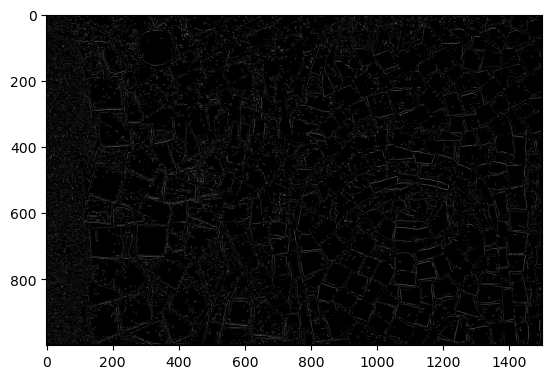

In [26]:
# Canny edge detection implementation

def convolve2d(image: np.ndarray, kernel: np.ndarray, mode: str = 'same') -> np.ndarray:
    """Convolve a 2D image with a 2D kernel.
    Args:
        image (np.ndarray): The image to be convolved.
        kernel (np.ndarray): The kernel to be convolved.
        mode (str, optional): The mode of the convolution. Defaults to 'same'.
    Returns:
        np.ndarray: The convolved image.
    """
    # Flip the kernel
    kernel = np.flipud(np.fliplr(kernel))
    # Calculate the output image size
    if mode == 'same':
        output_shape = image.shape
    elif mode == 'valid':
        output_shape = (image.shape[0] - kernel.shape[0] + 1, image.shape[1] - kernel.shape[1] + 1)
    elif mode == 'full':
        output_shape = (image.shape[0] + kernel.shape[0] - 1, image.shape[1] + kernel.shape[1] - 1)
    else:
        raise ValueError('Invalid mode.')
    # Pad the image
    pad_rows = kernel.shape[0] // 2
    pad_cols = kernel.shape[1] // 2
    image_padded = np.pad(image, ((pad_rows, pad_rows + output_shape[0] % 2), (pad_cols, pad_cols + output_shape[1] % 2)), mode='constant')
    # Convolve the image with the kernel
    image_convolved = np.zeros(output_shape)
    for x in range(output_shape[1]):
        for y in range(output_shape[0]):
            image_convolved[y, x] = (kernel * image_padded[y: y + kernel.shape[0], x: x + kernel.shape[1]]).sum()
    return image_convolved



def sobel_filter(image):
    # Define the Sobel kernels
    kernel_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
    kernel_y = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])

    # Convolve the kernels with the image
    gradient_x = convolve2d(image, kernel_x, mode='same')
    gradient_y = convolve2d(image, kernel_y, mode='same')

    # Compute the gradient magnitude and orientation
    gradient_magnitude = np.sqrt(gradient_x ** 2 + gradient_y ** 2)
    gradient_orientation = np.arctan2(gradient_y, gradient_x)

    return gradient_magnitude, gradient_orientation


def non_max_supression (gradient_magnitude, gradient_orientation):
    supressed = np.zeros(gradient_magnitude.shape)
    orientation_degrees = np.degrees(gradient_orientation) % 180

    for i in range(1, gradient_magnitude.shape[0] - 1):
        for j in range(1, gradient_magnitude.shape[1] - 1):
            q = 255
            r = 255

            # Find the neighbouring pixels in the direction of the gradient
            if (0 <= orientation_degrees[i, j] < 22.5) or (157.5 <= orientation_degrees[i, j] <= 180):
                q = gradient_magnitude[i, j + 1]
                r = gradient_magnitude[i, j - 1]
            elif 22.5 <= orientation_degrees[i, j] < 67.5:
                q = gradient_magnitude[i + 1, j - 1]
                r = gradient_magnitude[i - 1, j + 1]
            elif 67.5 <= orientation_degrees[i, j] < 112.5:
                q = gradient_magnitude[i + 1, j]
                r = gradient_magnitude[i - 1, j]
            elif 112.5 <= orientation_degrees[i, j] < 157.5:
                q = gradient_magnitude[i - 1, j - 1]
                r = gradient_magnitude[i + 1, j + 1]

            # If the current pixel is a local maximum, keep it
            if gradient_magnitude[i, j] >= q and gradient_magnitude[i, j] >= r:
                supressed[i, j] = gradient_magnitude[i, j]
            else:
                supressed[i, j] = 0

    return supressed


def canny_edge_detection(image, low_threshold_ratio=0.05, high_threshold_ratio=0.09):
    # Apply Gaussian filter
    image = gaussian_filter(image)

    # Apply Sobel filter
    gradient_magnitude, gradient_orientation = sobel_filter(image)

    # Apply non-maximum suppression
    gradient_magnitude = non_max_supression(gradient_magnitude, gradient_orientation)

    # Apply double threshold
    high_threshold = gradient_magnitude.max() * high_threshold_ratio
    low_threshold = high_threshold * low_threshold_ratio

    # Strong edges
    strong_i, strong_j = np.where(gradient_magnitude >= high_threshold)
    # Weak edges
    weak_i, weak_j = np.where((gradient_magnitude <= high_threshold) & (gradient_magnitude >= low_threshold))

    # Remove weak edges that are not connected to strong edges
    for i, j in zip(weak_i, weak_j):
        try:
            if (gradient_magnitude[i + 1, j - 1] >= high_threshold or
                gradient_magnitude[i + 1, j] >= high_threshold or
                gradient_magnitude[i + 1, j + 1] >= high_threshold or
                gradient_magnitude[i, j - 1] >= high_threshold or
                gradient_magnitude[i, j + 1] >= high_threshold or
                gradient_magnitude[i - 1, j - 1] >= high_threshold or
                gradient_magnitude[i - 1, j] >= high_threshold or
                gradient_magnitude[i - 1, j + 1] >= high_threshold):
                gradient_magnitude[i, j] = 255
            else:
                gradient_magnitude[i, j] = 0
        except IndexError as e:
            pass

    return gradient_magnitude


#Test Canny 
image = cv2.imread('mosaic_art/sample_1.jpeg', 0)
canny = canny_edge_detection(image)
plt.imshow(canny, cmap='gray')




    